In [1]:
import datetime
import os.path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from data_cleaning.ml_utils import available_indices, extract_data, get_sliding_data
from data_cleaning.utils import *
from data_cleaning.predict import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [15]:
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [2]:
# linear regression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


In [116]:
# Load data
DATA_FOLDER = os.path.join("data_cleaning", "data")
def path(filename):
    return os.path.join(DATA_FOLDER, filename)

orig_full_data = np.load(path("full_np_data.pickle.npy"))
inter_full_data = np.load(path("linear_inter.pickle.npy"))
spline_full_data = np.load(path("spline_inter.pickle.npy"))
orig_dates = np.load(path("dates.pickle.npy"))
names = pickle.load(open(path("filenames.pickle"), "rb"))
dates = np.load(path("dates.pickle.npy"))

In [9]:
# Select date for predictions
start_date = datetime.date(day=3, month=1, year=2013)
end_date = datetime.date(day=31, month=12, year=2015)

In [10]:
# Get data and valid measurements indices
inds, data, config = extract_data(orig_dates, start_date, end_date, inter_full_data)
inds2, data_spline, config2 = extract_data(orig_dates, start_date, end_date, spline_full_data)
start = config["start"]
end = config["end"]
assert inds == inds2
print("Available indices: ", inds)
print(np.array(names)[inds])
print(config)

Available indices:  [4, 9, 24, 33, 38, 42, 45, 46, 47, 50, 51, 52]
['data/raw/85004.csv' 'data/raw/85012.csv' 'data/raw/85030.csv'
 'data/raw/85040.csv' 'data/raw/85050.csv' 'data/raw/85054.csv'
 'data/raw/85063.csv' 'data/raw/85064.csv' 'data/raw/85065.csv'
 'data/raw/85073.csv' 'data/raw/85075.csv' 'data/raw/85076.csv']
{'start': 23013, 'end': 24105}


24106


(24106,)

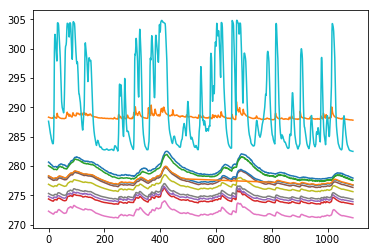

In [21]:
# Plot (linearly intrpolated) data acquired in that date range
print(len(inter_full_data[inds[2]]))
for part in data:
    plt.plot(part)


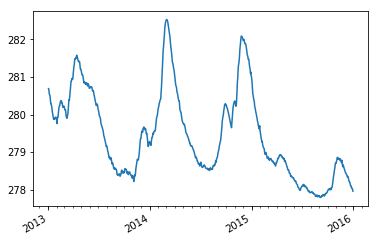

In [19]:


fig, ax = plt.subplots()
ax.plot(dates[start:end], data[0])

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years...
datemin = np.datetime64(dates[0])
datemax = np.datetime64(dates[-1], 'Y')
#ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '$%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 319


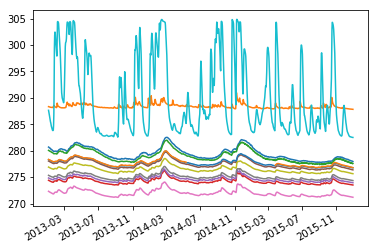

In [90]:
def get_data_plotter(datess):
    fig, ax = plt.subplots()
    #add_dates(ax, datess)
    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    def plotter(dat):
        ax.plot(datess, dat)
        
    return fig, ax, plotter

def add_dates(ax, datess, add_y=False):
    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years...
    datemin = np.datetime64(datess[0])
    datemax = np.datetime64(datess[-1], 'Y')
    #ax.set_xlim(datemin, datemax)
    if add_y:
        ax.set_ylim(270, 310)
    # format the coords message box
    def price(x):
        return '$%1.2f' % x
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

figg, axx, pl = get_data_plotter(dates[start:end])
for i, part in enumerate(orig_full_data[inds2, start:end]):
    print(i, sum(np.isnan(part)))
    pl(part)

plt.savefig("report/all.pdf")

In [73]:
len(inds2)

12

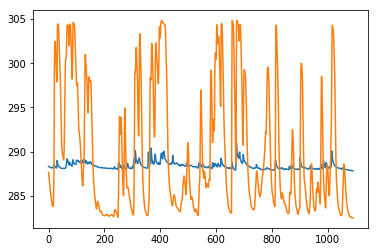

In [100]:
interesting = [1, 9]
#plt.plot(orig_full_data[inds2[11],start:end])
for j in interesting:
    plt.plot(orig_full_data[inds2[j],start:end])

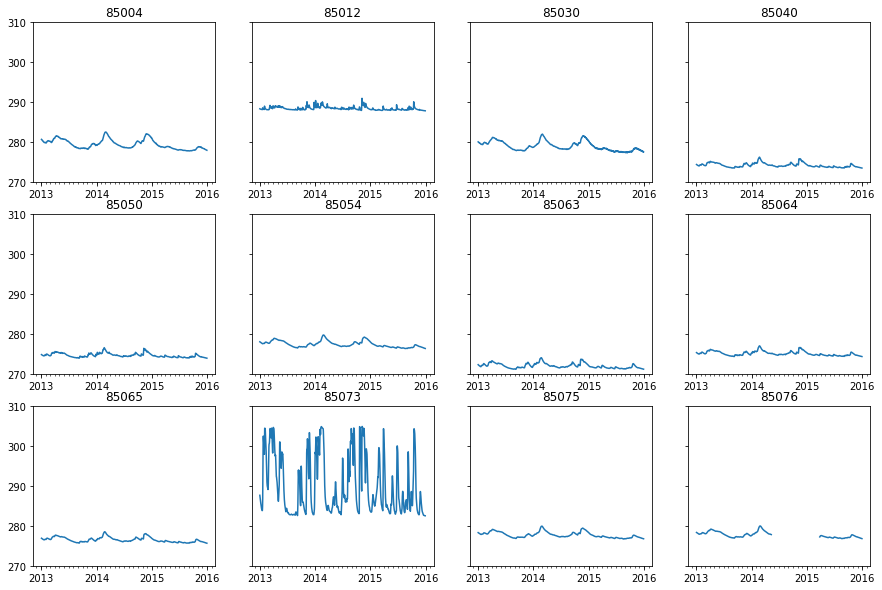

In [98]:
col = 4
N = len(inds2)
scale = 4
figg, ax = plt.subplots(N//col,col, sharey="row", figsize = (15, 10))
for i, a in enumerate(ax):
    for j,b in enumerate(a):
        n = i*col + j
        index = inds2[n]
        name = names[index].split("/")[-1].split(".")[0]
        b.set_title(name)
        add_dates(b, dates[start:end], add_y=1)
        b.plot(dates[start:end], orig_full_data[index,start:end])
#plt.suptitle("Sample measurements")
plt.savefig("report/multifig_measurements.pdf")

[4, 9, 24, 33, 38, 42, 45, 46, 47, 50, 51, 52]


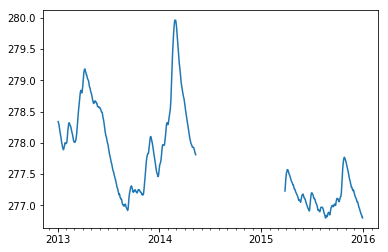

In [111]:
f, a = plt.subplots()
add_dates(a, dates[start:end])
a.plot(dates[start:end], orig_full_data[inds2[11],start:end])
print(inds2)

In [142]:
# Predict missing
objective = 11
strange = orig_full_data[inds[objective]][start:end]
print(start, end)
fst = find_fst_nan(strange)
snd = find_last_nan(strange)
#plt.plot(strange)
print(fst, snd)
helper = Holder(fst, snd)
clip = helper.clip
## Stack data

clipped_data = np.array(data)
clipped_data = np.array([clip(j) for j in clipped_data])
preds = predict_all(inds, clipped_data, objective, linear_model.LinearRegression, seed=18 + 5 + 2018)
best_strange = preds[0]
print(best_strange[0], best_strange[1])

23013 24105
494 813
12 773
0.999748926645884 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


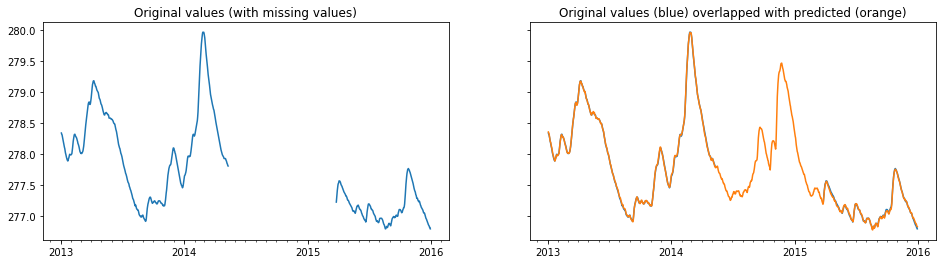

In [157]:
figg, (f,s) = plt.subplots(1,2, sharey="row", figsize = (16, 4))
add_dates(f, dates[start:end])
add_dates(s, dates[start:end])
f.plot(dates[start:end], strange)
f.set_title("Original values (with missing values)")
s.plot(dates[start:end], strange)
s.plot(dates[start:end], model.predict(np.array(data)[fit_ind].T))
s.set_title("Original values (blue) overlapped with predicted (orange)")
plt.savefig("report/missing_prediction.pdf")

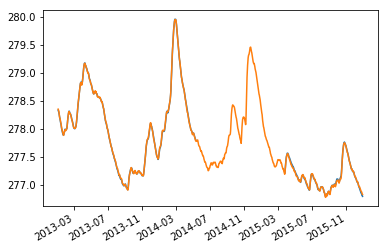

In [143]:
fig, ax, plotter = get_data_plotter(dates[start:end])
plotter(strange)
r2, fit_ind, model = best_strange
plotter(model.predict(np.array(data)[fit_ind].T))


In [169]:
ftt = []
inds_good = inds2[:]
inds_good.pop(11)
print(orig_full_data.shape)
# Gradient boositing regression se obnasa neprimerno bolje
for pump in interesting:
    print(pump)
    preds = predict_all(inds_good, np.array(orig_full_data)[inds_good, start:end], pump, SVR, seed=18 + 5 + 2018)
    best = preds[0]
    print(best[0], best[1])
    ftt.append(best)


(53, 24106)
1
11 1092
0.8968515782941545 [4, 7]
9
11 1092
0.6251075002729759 [0, 4, 6]


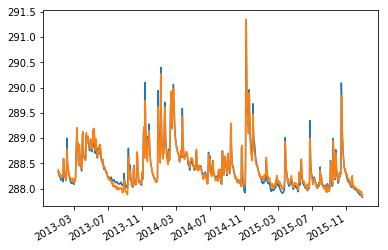

In [164]:
inddd = 0
a = ftt[inddd]
fig, ax, plotter = get_data_plotter(dates[start:end])
plotter(orig_full_data[inds2[interesting[inddd]], start:end])
r2, fit_ind, model = a
plotter(model.predict(np.array(data)[fit_ind].T))

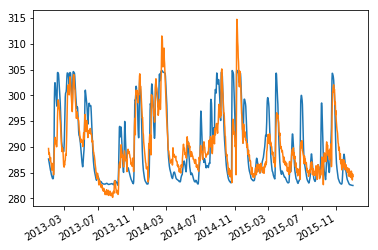

In [165]:
inddd = 1
a = ftt[inddd]
fig, ax, plotter = get_data_plotter(dates[start:end])
plotter(orig_full_data[inds2[interesting[inddd]], start:end])
r2, fit_ind, model = a
plotter(model.predict(np.array(data)[fit_ind].T))

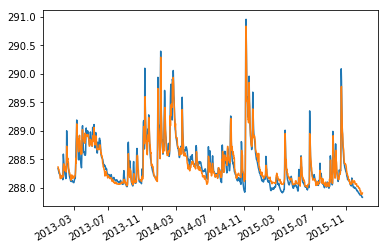

In [167]:
inddd = 0
a = ftt[inddd]
fig, ax, plotter = get_data_plotter(dates[start:end])
plotter(orig_full_data[inds2[interesting[inddd]], start:end])
r2, fit_ind, model = a
plotter(model.predict(np.array(data)[fit_ind].T))

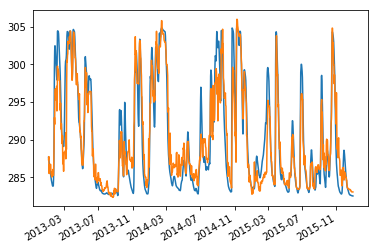

In [168]:
inddd = 1
a = ftt[inddd]
fig, ax, plotter = get_data_plotter(dates[start:end])
plotter(orig_full_data[inds2[interesting[inddd]], start:end])
r2, fit_ind, model = a
plotter(model.predict(np.array(data)[fit_ind].T))